In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune

from functions.train_test import train, test,train_kd
from functions.data_loader import get_data_loader,load_checkpoint
from models.vit import ViT 
from functions.helpers import count_parameters


In [2]:
torch.manual_seed(42)

In [3]:
train_loader, test_loader = get_data_loader(
    80, 2, "datasets/cifar-100/cifar-100-python", download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
teacher_model = ViT(
    image_size=32,
    patch_size=4,
    num_classes=100,
    dim=64,
    depth=4,
    heads=8,
    mlp_dim=256,
    dropout=0.1,
    feature_distill=True
).to("cuda")

teacher_save_path = "save_model/cifar-100/vit_base"
teacher_load_path = f"{teacher_save_path}/best_model.pt"

student_kd_save_path = "save_model/cifar-100/vit_16_student_kd_cifar-100"

student_kd = ViT(
    image_size=32,
    patch_size=4,
    num_classes=100,
    dim=64,
    depth=3,
    heads=6,
    mlp_dim=256,
    dropout=0.1,
    feature_distill=True

).to("cuda")


In [5]:
student_featurekd_save_path='save_model/cifar-100/vit_featurekd'

Epoch 1/300, Loss: 2.988400924682617
Current Learning Rate: 0.000999972584682756
accuracy: 6.25%
Test Accuracy: 9.78%
max_test_accuracy : 9.78
Epoch 2/300, Loss: 2.5810503566741945
Current Learning Rate: 0.0009998903417374227
accuracy: 13.75%
Test Accuracy: 15.16%
max_test_accuracy : 15.16
Epoch 3/300, Loss: 2.403493323516846
Current Learning Rate: 0.0009997532801828658
accuracy: 17.5%
Test Accuracy: 20.05%
max_test_accuracy : 20.05
Epoch 4/300, Loss: 2.2805775993347166
Current Learning Rate: 0.0009995614150494292
accuracy: 17.5%
Test Accuracy: 21.75%
max_test_accuracy : 21.75
Epoch 5/300, Loss: 2.171780045890808
Current Learning Rate: 0.000999314767377287
accuracy: 22.5%
Test Accuracy: 24.35%
max_test_accuracy : 24.35
Epoch 6/300, Loss: 2.0781804637908934
Current Learning Rate: 0.0009990133642141358
accuracy: 30.0%
Test Accuracy: 26.32%
max_test_accuracy : 26.32
Epoch 7/300, Loss: 2.0015645839691163
Current Learning Rate: 0.000998657238612229
accuracy: 37.5%
Test Accuracy: 28.47%
max_

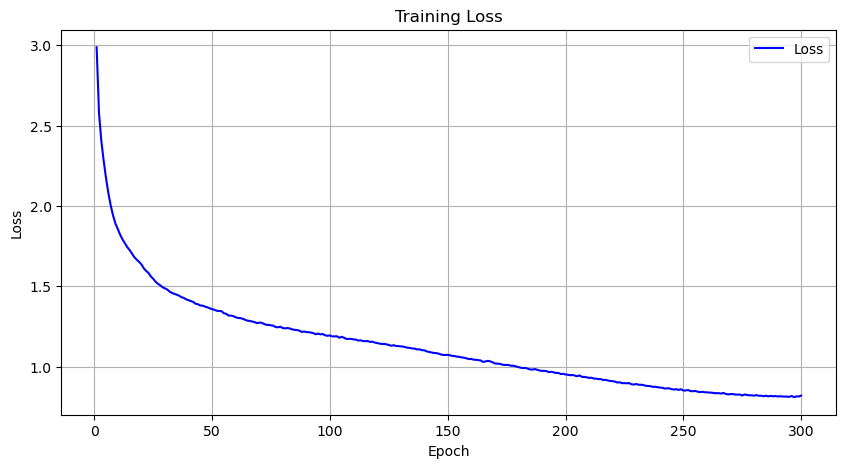

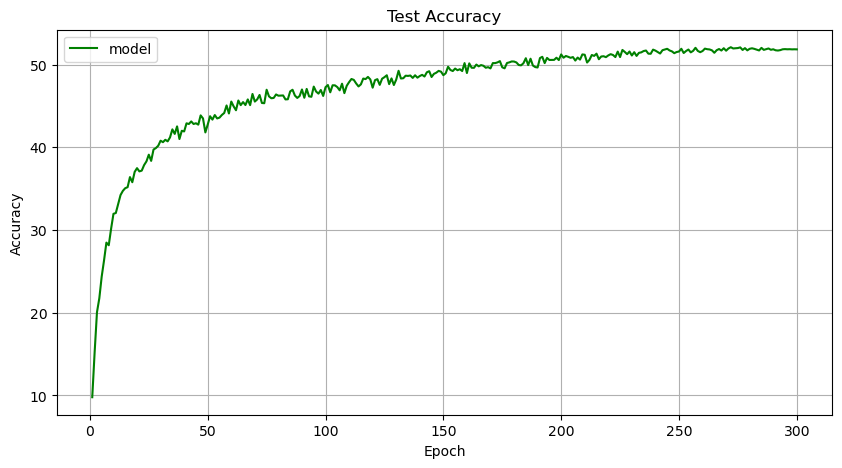

In [6]:

train_kd(
    student_kd,
    teacher_model,
    train_loader,
    test_loader,
    T=4,
    alpha=0.2,
    epochs=300,
    learning_rate=0.001,
    device='cuda',
    weight_decay=0.0005,
    feature_distill=True,
    save_path=student_featurekd_save_path,
    load_path_teacher=teacher_load_path,
)

In [ ]:
train(
    teacher_model,
    train_loader,
    test_loader,
    epochs=500,
    learning_rate=0.0001,
    device="cuda",
    weight_decay=0.0005,
    # save_path=teacher_save_path,
    # load_path=teacher_load_path
)

In [ ]:
print(f"Total number of parameters: {count_parameters(student_kd)}")

In [ ]:
student_base_save_path = "save_model/cifar-100/vit_16_student_base_cifar-100"
student_base_model = ViT(
    image_size=32,
    patch_size=4,
    num_classes=100,
    dim=64,
    depth=3,
    heads=6,
    mlp_dim=256,
    dropout=0.1,
).to("cuda")

train(
    student_base_model,
    train_loader,
    test_loader,
    epochs=300,
    learning_rate=0.001,
    weight_decay=0.0005,
    device="cuda",
    # save_path=student_base_save_path,
)

In [ ]:
load_checkpoint(student_kd,f"{student_kdsoft_save_path}/best_model.pt")

In [ ]:
test(student_kd,test_loader,'cuda')

In [ ]:
pruning_method = prune.L1Unstructured

In [ ]:
for name, module in teacher_model.named_modules():
    if isinstance(module, nn.Linear):
        prune.ln_structured(module, name='weight', amount=0.9, n=1, dim=0)
        print(module)


In [ ]:
teacher_model

In [ ]:
for name, layer in teacher_model.named_children():
    print(name)

In [ ]:
module = teacher_model.transformer.layers[0]

In [ ]:
for name, param in teacher_model.named_parameters():
    if "bias" in name:
        param= nn.Parameter(torch.sparse.FloatTensor(param.shape).to('cuda'))
        print(param)
    # else:
    #     print(param)


In [ ]:
for name, module in teacher_model.named_modules():
    print(module.transformer.layers[0][0].fn.to_qkv.weight)

In [ ]:
module

In [ ]:
attention = module[0].fn

In [ ]:
print(list(attention.named_parameters()))

In [ ]:
linear_layer = attention.to_qkv

In [ ]:
linear_layer

In [ ]:
prune.random_unstructured(linear_layer, name="weight", amount=0.3)

In [ ]:
teacher_model.transformer.layers[0][0].fn.to_qkv.weight